In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt

In [71]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("data/edges_data.csv")
df_2020 = pd.read_csv("data/scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data/its_scats_sites_aug-2020.csv")

In [72]:
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)

In [73]:
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)

In [74]:
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)

In [75]:
df  = pd.concat([March2025, April2025], ignore_index=True)

In [76]:
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [77]:
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [78]:
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)

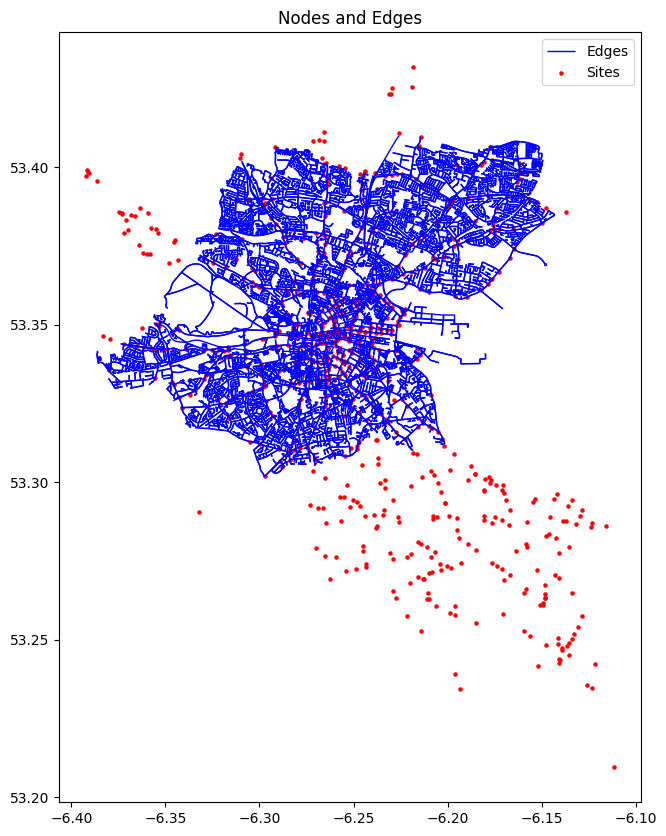

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges first (usually as lines)
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

# Plot nodes on top (usually as points)
geo_sites.plot(ax=ax, color='red', markersize=5, label='Sites')

# Optional: add a legend and title
plt.legend()
plt.title("Nodes and Edges")

plt.show()

In [80]:
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)

In [101]:
df_small = df[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')

C:\Users\user1\AppData\Local\Temp\ipykernel_1548\4000184562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
c:\Users\user1\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [102]:
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")

gdf.head()


,End_Time,Site,Detector,Sum_Volume,SiteID,geometry
0,20250313010000,58,6,0,58.0,POINT (-6.26523 53.35605)
1,20250313010000,58,7,5,58.0,POINT (-6.26523 53.35605)
2,20250313010000,58,8,0,58.0,POINT (-6.26523 53.35605)
3,20250313010000,58,9,0,58.0,POINT (-6.26523 53.35605)
4,20250313010000,58,10,0,58.0,POINT (-6.26523 53.35605)


In [103]:
gdf=gdf.drop("SiteID", axis = 1)
gdf["End_Time"] = pd.to_datetime(gdf["End_Time"], format="%Y%m%d%H%M%S")
gdf.head()

,End_Time,Site,Detector,Sum_Volume,geometry
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605)
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605)
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605)
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605)
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605)


In [104]:
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)

In [ ]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')
joined = joined.rename(columns={"index_right": "Grid_ID"})

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('Grid_ID')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells


In [ ]:
grid.index.name = "Grid_ID"
grid.head()

#grid.set_index("Grid_ID", inplace=True)

,geometry,Sum_volume
Grid_ID,,
0,"POLYGON ((-6.36199 53.3018, -6.36199 53.31262,...",0.0
1,"POLYGON ((-6.36199 53.31262, -6.36199 53.32344...",0.0
2,"POLYGON ((-6.36199 53.32344, -6.36199 53.33426...",0.0
3,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507...",1857254.0
4,"POLYGON ((-6.36199 53.34507, -6.36199 53.35589...",2035809.0


In [110]:
joined = joined.drop(columns=["Sum_volume"])
joined.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605),45.0
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605),45.0
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605),45.0
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605),45.0
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605),45.0


In [112]:
joined_eval = joined.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


In [ ]:
joined_eval = joined_eval.sort_values("Grid_ID")
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


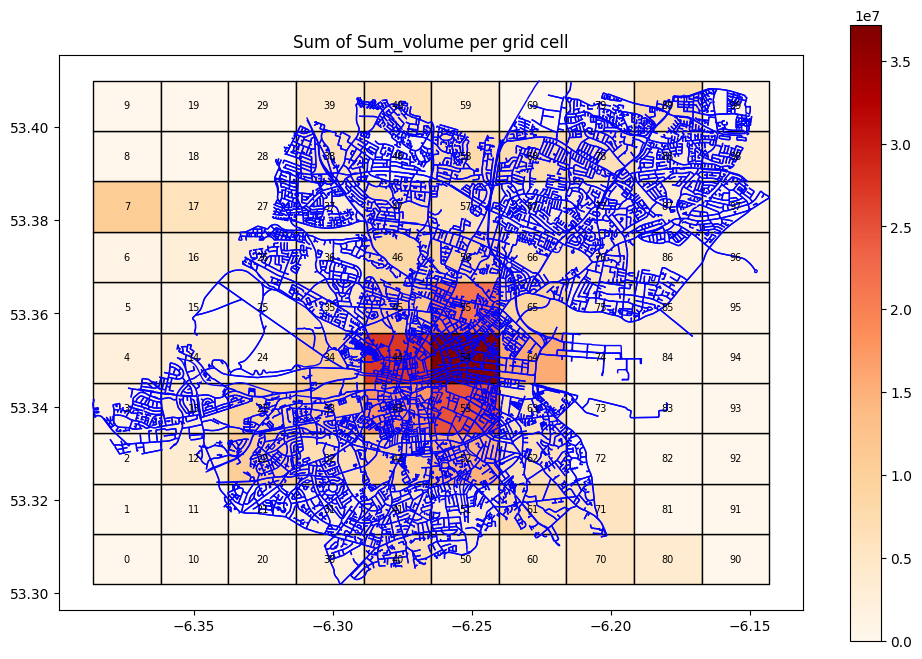

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid.plot(column='Sum_volume', ax=ax, cmap='OrRd', legend=True, edgecolor='k')
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

for idx, row in grid.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, str(row.name), fontsize=7, color="black",
                ha="center", va="center")
        
plt.title("Sum of Sum_volume per grid cell")
plt.show()

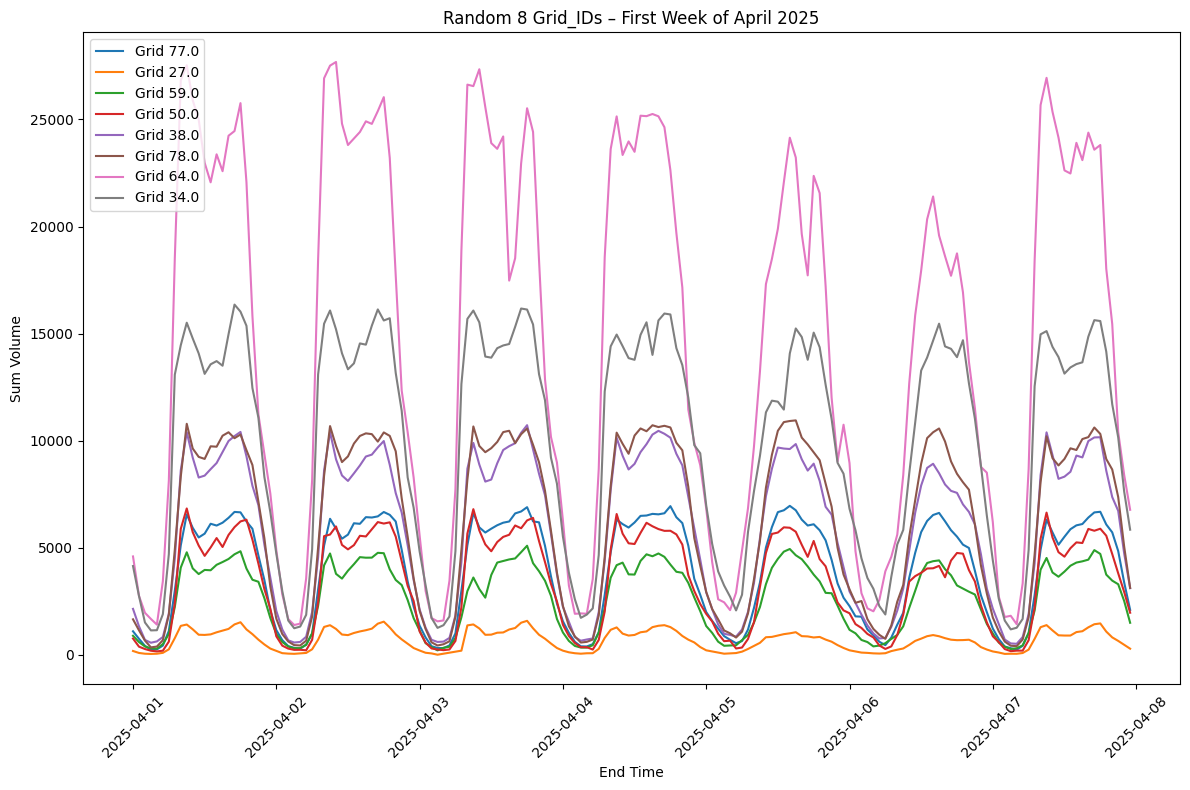

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Define the time window (first week of April 2025)
start = pd.Timestamp("2025-04-01")
end   = pd.Timestamp("2025-04-07 23:59:59")

# 2. Filter the data for that week
week_data = joined_eval[(joined_eval["End_Time"] >= start) & (joined_eval["End_Time"] <= end)]

# 3. Pick 8 random Grid_IDs from those available in that week
random_ids = np.random.choice(week_data["Grid_ID"].unique(), size=8, replace=False)

# 4. Filter again for just those IDs
subset = week_data[week_data["Grid_ID"].isin(random_ids)]

# 5. Plot
plt.figure(figsize=(12, 8))
for gid in random_ids:
    temp = subset[subset["Grid_ID"] == gid]
    plt.plot(temp["End_Time"], temp["Sum_Volume"], label=f"Grid {gid}")

plt.xlabel("End Time")
plt.ylabel("Sum Volume")
plt.title("Random 8 Grid_IDs – First Week of April 2025")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
bins = [0, 7, 10, 16, 20, 24]  # hours
labels = ["00-07", "07-10", "10-16", "16-20", "20-24"]

# extract hour of day
joined_eval["hour"] = joined_eval["End_Time"].dt.hour

# assign each row into a time bin
joined_eval["time_bin"] = pd.cut(joined_eval["hour"], bins=bins, labels=labels, right=False)

# also extract just the date (for grouping day by day)
joined_eval["date"] = joined_eval["End_Time"].dt.date

# now group by Grid_ID, date, and time_bin
grouped = (
    joined_eval
    .groupby(["Grid_ID", "date", "time_bin"])["Sum_Volume"]
    .sum()
    .reset_index()
)

grouped.head()

C:\Users\user1\AppData\Local\Temp\ipykernel_1548\1597695665.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Grid_ID", "date", "time_bin"])["Sum_Volume"]


,Grid_ID,date,time_bin,Sum_Volume
0,3.0,2025-03-01,00-07,2877
1,3.0,2025-03-01,07-10,3029
2,3.0,2025-03-01,10-16,20766
3,3.0,2025-03-01,16-20,12818
4,3.0,2025-03-01,20-24,7405


In [ ]:
grouped = pd.merge(grouped, grid, left_on="Grid_ID", right_index=True, how="left")
grouped.drop(columns=["Sum_volume"], inplace=True)
grouped.head()

,Grid_ID,date,time_bin,Sum_Volume,geometry
0,3.0,2025-03-01,00-07,2877,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
1,3.0,2025-03-01,07-10,3029,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
2,3.0,2025-03-01,10-16,20766,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
3,3.0,2025-03-01,16-20,12818,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
4,3.0,2025-03-01,20-24,7405,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."


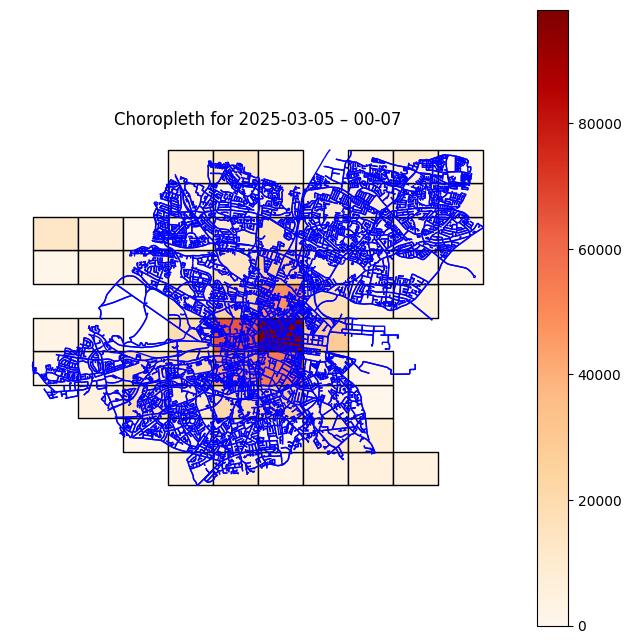

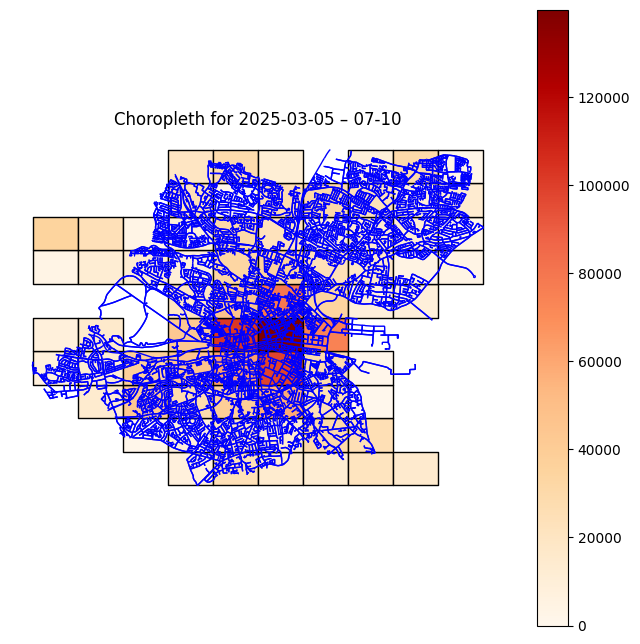

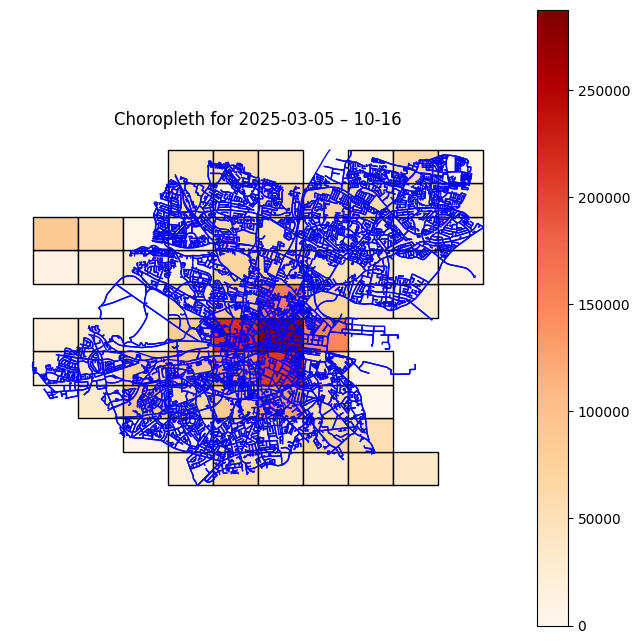

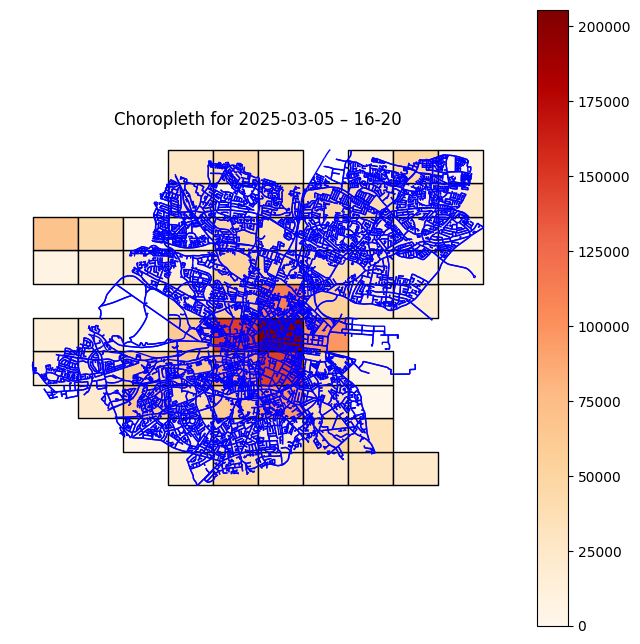

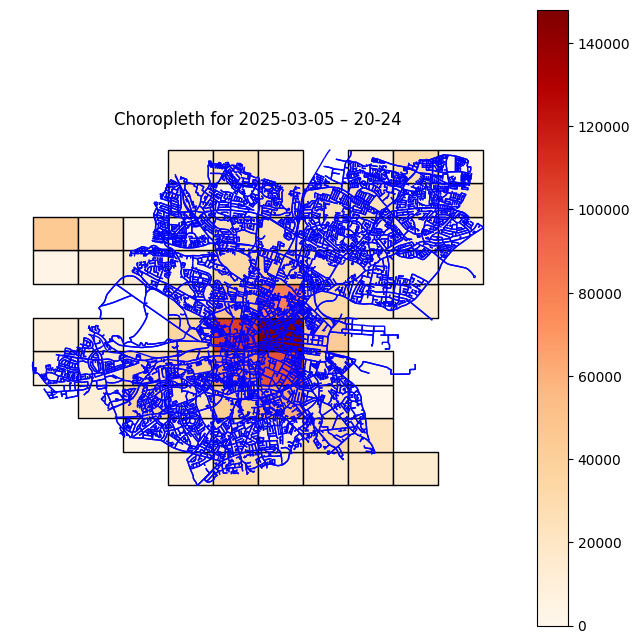

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# make sure grouped is a GeoDataFrame
grouped_gdf = gpd.GeoDataFrame(grouped, geometry="geometry")

# 1. pick a random day
random_day = np.random.choice(grouped_gdf["date"].unique())
day_data = grouped_gdf[grouped_gdf["date"] == random_day]

# 2. get the time bins for that day
time_bins = sorted(day_data["time_bin"].unique())

# 3. loop over each time bin and plot separately
for tb in time_bins:
    subset = day_data[day_data["time_bin"] == tb]

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # plot choropleth
    subset.plot(
        column="Sum_Volume",
        cmap="OrRd",
        legend=True,
        ax=ax,
        edgecolor="black"
    )
    
    # overlay geo_edges
    geo_edges.plot(ax=ax, color="blue", linewidth=1, label="Edges")
    
    ax.set_title(f"Choropleth for {random_day} – {tb}")
    ax.axis("off")
    plt.show()


Grid_ID
3.0     225
4.0     225
6.0     225
7.0     225
12.0    225
       ... 
89.0    225
96.0    225
97.0    225
98.0    225
99.0    225
Name: count, Length: 72, dtype: int64

In [114]:
geo_edges["start_point"] = geo_edges.geometry.apply(lambda x: Point(x.coords[0]))
geo_edges["end_point"]   = geo_edges.geometry.apply(lambda x: Point(x.coords[-1]))

# 2. Make GeoDataFrames for start and end points
start_gdf = gpd.GeoDataFrame(geo_edges[["start_point"]], geometry="start_point", crs=geo_edges.crs)
end_gdf   = gpd.GeoDataFrame(geo_edges[["end_point"]], geometry="end_point", crs=geo_edges.crs)

# 3. Spatial join each point set with the grid polygons
start_joined = gpd.sjoin(start_gdf, grid, how="left", predicate="within")
end_joined   = gpd.sjoin(end_gdf, grid, how="left", predicate="within")

# 4. Add Grid_IDs back to geo_edges
geo_edges["start_grid"] = start_joined["Grid_ID"].values
geo_edges["end_grid"]   = end_joined["Grid_ID"].values

geo_edges.head()

,u,v,key,osmid,highway,lanes,maxspeed,name,oneway,ref,...,access,tunnel,bridge,width,junction,est_width,start_point,end_point,start_grid,end_grid
0,389279,1396858852,0,"[1288830596, 292236197, 1179644327, 1179644328...",secondary,2,"['30', '50']",Essex Quay,True,R148,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-6.26763 53.34534),POINT (-6.26999 53.34513),44.0,44.0
1,389281,26165090,0,14039949,unclassified,NaN,30,York Street,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-6.26586 53.33959),POINT (-6.26433 53.33926),43.0,53.0
2,389281,135109542,0,532427444,secondary,3,30,Aungier Street,False,R114,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-6.26586 53.33959),POINT (-6.26566 53.34048),43.0,43.0
3,389281,2384200130,0,532427444,secondary,3,30,Aungier Street,False,R114,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-6.26586 53.33959),POINT (-6.26611 53.33854),43.0,43.0
4,389292,3594514232,0,"[506780985, 3789703]",secondary,4,50,Beresford Place,True,R105,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-6.25494 53.34828),POINT (-6.25495 53.34866),54.0,54.0


In [115]:
joined.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605),45.0
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605),45.0
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605),45.0
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605),45.0
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605),45.0


In [137]:
geo_nodes = gpd.sjoin(
    geo_nodes, grid, how="left", predicate="within"
)
geo_nodes.head()

,osmid,y,x,street_count,highway,ref,junction,railway,geometry,Grid_ID,Sum_volume
0,385708,53.388802,-6.353715,3,NaN,NaN,NaN,NaN,POINT (-6.35371 53.3888),18.0,0.0
1,385713,53.385852,-6.374721,4,traffic_signals,NaN,NaN,NaN,POINT (-6.37472 53.38585),7.0,10664564.0
2,385738,53.389050,-6.375863,3,NaN,NaN,NaN,NaN,POINT (-6.37586 53.38905),8.0,0.0
3,385745,53.394989,-6.375190,3,traffic_signals,NaN,NaN,NaN,POINT (-6.37519 53.39499),8.0,0.0
4,385746,53.389695,-6.377564,3,motorway_junction,2,NaN,NaN,POINT (-6.37756 53.38969),8.0,0.0


In [118]:
joined_count = joined.groupby("Grid_ID")["Site"].nunique()
joined_count.loc[[52,53,54,55,44,43,64,63]]

Grid_ID
52.0    24
53.0    41
54.0    51
55.0    21
44.0    35
43.0    24
64.0    19
63.0    11
Name: Site, dtype: int64

C:\Users\user1\AppData\Local\Temp\ipykernel_1548\2943669046.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


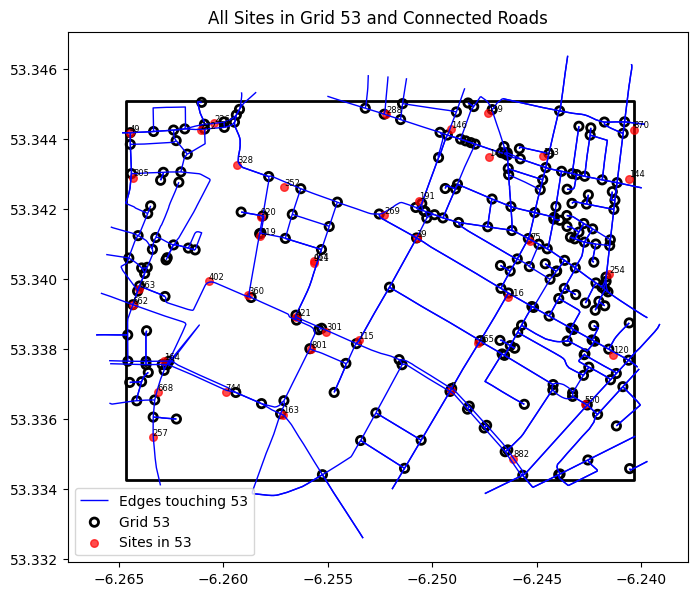

In [ ]:
# 1. get all sites in Grid_ID 53 (keep duplicates)
sites53 = joined[joined["Grid_ID"] == 53]
uniques = sites53.drop_duplicates(subset=["Site"])

# 2. select edges connected to Grid_ID 53
edges53 = geo_edges[(geo_edges["start_grid"] == 53) | (geo_edges["end_grid"] == 53)]
nodes53 = geo_nodes[geo_nodes["Grid_ID"] == 53]

# 3. get the polygon of Grid_ID 53
grid53 = grid.loc[[53]]

# 4. plot
fig, ax = plt.subplots(figsize=(8, 8))

# plot grid polygon
grid53.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="Grid 53")

# plot roads
edges53.plot(ax=ax, color="blue", linewidth=1, label="Edges touching 53")
#nodes53.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="Grid 53")

# plot all site points (with duplicates)
uniques.plot(ax=ax, color="red", markersize=30, alpha=0.7, label="Sites in 53")

for idx, row in uniques.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        x, y = row.geometry.x, row.geometry.y
        ax.text(x, y, str(row["Site"]),
                fontsize=6, color="black",
                ha="left", va="bottom")

ax.set_title("All Sites in Grid 53 and Connected Roads")
ax.legend()
plt.show()


In [125]:
sites53.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
1879,2025-03-13 01:00:00,7,1,83,POINT (-6.24912 53.33682),53.0
1880,2025-03-13 01:00:00,7,2,7,POINT (-6.24912 53.33682),53.0
1881,2025-03-13 01:00:00,7,3,34,POINT (-6.24912 53.33682),53.0
1882,2025-03-13 01:00:00,7,4,29,POINT (-6.24912 53.33682),53.0
1883,2025-03-13 01:00:00,7,5,14,POINT (-6.24912 53.33682),53.0


In [135]:
# 1. get all sites in Grid_ID 53 (keep duplicates)
selected = sites53[sites53["Site"].isin([352, 328, 920, 919])]
selected.head()


,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
8029,2025-03-11 07:00:00,919,1,127,POINT (-6.25824 53.34123),53.0
8030,2025-03-11 07:00:00,919,2,6,POINT (-6.25824 53.34123),53.0
8031,2025-03-11 07:00:00,919,3,4,POINT (-6.25824 53.34123),53.0
8032,2025-03-11 07:00:00,919,4,6,POINT (-6.25824 53.34123),53.0
8033,2025-03-11 07:00:00,919,5,6,POINT (-6.25824 53.34123),53.0


In [129]:
geo_sites_grid = gpd.sjoin(
    geo_sites, grid, how="left", predicate="within"
)
geo_sites_grid[geo_sites_grid["Grid_ID"] == 53].head()

,SiteID,Site_Description_Cap,Site_Description_Lower,Region,Lat,Long,geometry,Grid_ID,Sum_volume
6,7.0,BAGGOT ST @ FITZWILLIAM ST,baggot st @ fitzwilliam st,SCITY,53.336815,-6.249116,POINT (-6.24912 53.33682),53.0,24839211.0
37,39.0,CLARE ST @ MERRION SQ,clare st @ merrion sq,CCITY,53.341155,-6.250742,POINT (-6.25074 53.34116),53.0,24839211.0
47,49.0,DAME ST @ GEORGES ST,dame st @ georges st,CCITY,53.344169,-6.264473,POINT (-6.26447 53.34417),53.0,24839211.0
70,75.0,FENIAN ST @ HOLLES ST,fenian st @ holles st,CCITY,53.341085,-6.245314,POINT (-6.24531 53.34108),53.0,24839211.0
105,115.0,MERRION ROW @ MERRION ST,merrion row @ merrion st,CCITY,53.338255,-6.253528,POINT (-6.25353 53.33826),53.0,24839211.0


In [154]:
sel_detectors = selected.groupby("Site")["Detector"].nunique()
site352=selected[selected["Site"] == 352]
site352_grouped=site352.groupby("Detector")["Sum_Volume"].sum().reset_index().sort_values("Sum_Volume", ascending=False)
site352_time= site352.groupby("End_Time")
site352_grouped.head()



,Detector,Sum_Volume
2,2,164997
3,3,93697
20,20,29759
12,12,8796
7,7,8590


In [151]:
# take top 4 detectors for each End_Time
top_detectors = (
    site352.groupby("End_Time", group_keys=False)
    .apply(lambda g: g.nlargest(4, "Sum_Volume"))
)

# rank within each End_Time
top_detectors["rank"] = (
    top_detectors.groupby("End_Time").cumcount() + 1
)

# pivot wider: one row per End_Time, columns for top 4 detectors and volumes
result = top_detectors.pivot_table(
    index="End_Time",
    columns="rank",
    values=["Detector", "Sum_Volume"],
    aggfunc="first"
)

# flatten MultiIndex column names
result.columns = [f"{col}_{rank}" for col, rank in result.columns]
result = result.reset_index()

result.head()

C:\Users\user1\AppData\Local\Temp\ipykernel_1548\3494269279.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(4, "Sum_Volume"))


,End_Time,Detector_1,Detector_2,Detector_3,Detector_4,Sum_Volume_1,Sum_Volume_2,Sum_Volume_3,Sum_Volume_4
0,2025-03-01 00:00:00,2,3,20,6,209,103,29,6
1,2025-03-01 01:00:00,20,4,6,7,20,3,3,3
2,2025-03-01 02:00:00,20,0,1,2,1,0,0,0
3,2025-03-01 03:00:00,20,0,1,2,1,0,0,0
4,2025-03-01 04:00:00,0,1,2,3,0,0,0,0


In [152]:
result=result.sort_values("Sum_Volume_1", ascending=False)
result

,End_Time,Detector_1,Detector_2,Detector_3,Detector_4,Sum_Volume_1,Sum_Volume_2,Sum_Volume_3,Sum_Volume_4
273,2025-03-12 09:00:00,2,3,7,6,398,127,24,20
490,2025-04-07 09:00:00,2,3,7,12,363,146,26,23
105,2025-03-05 09:00:00,2,3,7,6,361,151,21,19
514,2025-04-08 09:00:00,2,3,7,6,359,159,23,21
683,2025-04-15 10:00:00,2,3,11,7,358,127,19,18
...,...,...,...,...,...,...,...,...,...
28,2025-03-02 04:00:00,0,1,2,3,0,0,0,0
818,2025-04-21 01:00:00,0,1,2,3,0,0,0,0
796,2025-04-20 03:00:00,0,1,2,3,0,0,0,0
603,2025-04-12 02:00:00,0,1,2,3,0,0,0,0
